## 1. Imports

In [ ]:
# !pip install timm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import timm
import cv2
import math
import io

from PIL import Image
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from tqdm.auto import tqdm

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN = True

## 2. Загрузка датасета

In [3]:
# Загрузка тренировочного датасета
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/t-RTTSAH2ZDssg) -o train_dataset_aligned.zip
! unzip -qq train_dataset_aligned.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  195M  100  195M    0     0   9.9M      0  0:00:19  0:00:19 --:--:-- 13.8M


In [4]:
df_train = pd.read_csv('./train_dataset_aligned/train_dataset.csv', index_col=0)
df_train.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
179285,179286.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,824,128,859,125,828,152,826,173,863,168
173217,173218.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,291,254,378,258,339,306,297,354,370,357
178573,178574.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,395,181,476,181,432,228,390,262,481,266
178018,178019.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,891,591,1173,597,1035,741,909,897,1179,903
174008,174009.jpg,-1,1,1,1,-1,-1,-1,-1,-1,...,253,269,384,271,318,338,253,396,382,396


In [5]:
# Кодируем метки классов (id изображений из датасета) с помощью LabelEncoder
le = LabelEncoder()
le.fit(df_train['id'])

LabelEncoder()

In [6]:
NUM_CLASSES = le.classes_.shape[0]
print("Количество классов:", NUM_CLASSES)

Количество классов: 400


In [7]:
# Загрузка валидационного датасета
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/lkX9a95HkTvpAA) -o val_dataset_aligned.zip
! unzip -qq val_dataset_aligned.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 19.8M  100 19.8M    0     0  3123k      0  0:00:06  0:00:06 --:--:-- 4333k


In [8]:
df_val = pd.read_csv('./val_dataset_aligned/val_dataset.csv', index_col=0)
df_val.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
180477,180478.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,78,166,144,165,85,211,78,241,150,243
169375,169376.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,265,118,322,129,298,159,255,175,315,185
177090,177091.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,145,132,207,130,167,169,149,194,212,191
130857,130858.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,105,190,164,182,129,227,117,251,163,247
14714,014715.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,92,116,143,111,118,145,102,162,141,159


## 3. Создание Датасета для модели

In [9]:
# трансформации картинок перед обучением
transform = v2.Compose([
      v2.PILToTensor(),
      v2.ToDtype(torch.float32, scale=True),
      v2.Resize((256, 256)),
      v2.RandomHorizontalFlip(p=0.5), # Используем горизонтальное зеркальное отображение как аугментацию
      v2.Normalize(mean=[0., 0., 0.],
                      std=[1., 1., 1.]),
])

In [10]:
# Подготовка кастомного датасета
class FaceIDDataset(Dataset):
    def __init__(self, dataframe, root_folder, label_encoder, transforms=None):

        self.df = dataframe
        self.root_folder = root_folder
        self.transforms = transforms
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        """
        row = self.df.iloc[idx]
        image_id = row['image_id']
        face_id = self.label_encoder.transform([row['id']])

        image = Image.open(self.root_folder + image_id)
        # image = np.array(image)

        if self.transforms:
            image = self.transforms(image)

        return image, image_id, face_id


def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1], torch.tensor(batch[2], dtype=torch.int64).view(-1,)

In [11]:
# Создаем объекты классов кастомных датасетов для обучения и валидации
train_dataset = FaceIDDataset(df_train, "./train_dataset_aligned/", le, transforms=transform)
val_dataset = FaceIDDataset(df_val, "./val_dataset_aligned/", le, transforms=transform)

In [12]:
# Создаем даталоадеры из кастомных датасетов
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [13]:
# Проверим работу даталоадера
image, image_id, face_id = next(iter(train_dataloader))

/tmp/ipython-input-2470376166.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return images, batch[1], torch.tensor(batch[2], dtype=torch.int64).view(-1,)



##4. Построение модели для распознавания лиц

In [14]:
class Backbone(nn.Module):
    """Backbone NNetwork for Face Recognition (EfficientNet B3 by default)"""
    def __init__(self, model_name="efficientnet_b3", feat_dim=512):
        super().__init__()
        # timm.list_models(pretrained=True)
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=1)

        self.feat_emb = nn.Linear(384 * 8 * 8, feat_dim)

    def forward(self, x):
        x = self.backbone(x)[0]
        x = x.view(x.size(0), -1)
        x = self.feat_emb(x)

        return x

In [15]:
summary(Backbone(model_name="efficientnet_b3").to(DEVICE), (3, 256, 256))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]           1,080
          Identity-2         [-1, 40, 128, 128]               0
              SiLU-3         [-1, 40, 128, 128]               0
    BatchNormAct2d-4         [-1, 40, 128, 128]              80
            Conv2d-5         [-1, 40, 128, 128]             360
          Identity-6         [-1, 40, 128, 128]               0
              SiLU-7         [-1, 40, 128, 128]               0
    BatchNormAct2d-8         [-1, 40, 128, 128]              80
          Identity-9         [-1, 40, 128, 128]               0
           Conv2d-10             [-1, 10, 1, 1]             410
             SiLU-11             [-1, 10, 1, 1]               0
           Conv2d-12             [-1, 40, 1, 1]             440
          Sigmoid-13             [-1, 40, 1, 1]               0
    SqueezeExcite-14         [-1, 40, 1

In [17]:
class ArcFaceLoss(nn.Module):
    """
    Класс для имплементации ArcFaceLoss
    https://arxiv.org/abs/1801.07698
    """
    def __init__(self, feat_dim=512, num_class=NUM_CLASSES, scale=32, margin=0.5, easy_margin=False):

        super().__init__()
        self.scale = scale
        self.margin = margin
        self.ce = nn.CrossEntropyLoss()
        self.weight = nn.Parameter(torch.FloatTensor(num_class, feat_dim))
        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

        nn.init.xavier_uniform_(self.weight)

    def forward(self, embedding: torch.Tensor, ground_truth):

        cos_theta = F.linear(F.normalize(embedding), F.normalize(self.weight)).clamp(-1 + 1e-7, 1 - 1e-7)
        sin_theta = torch.sqrt((1.0 - torch.pow(cos_theta, 2)).clamp(-1 + 1e-7, 1 - 1e-7))
        phi = cos_theta * self.cos_m - sin_theta * self.sin_m
        if self.easy_margin:
            phi = torch.where(cos_theta > 0, phi, cos_theta)
        else:
            phi = torch.where(cos_theta > self.th, phi, cos_theta - self.mm)

        one_hot = torch.zeros(cos_theta.size(), device='cuda')
        one_hot.scatter_(1, ground_truth.view(-1, 1).long(), 1)

        output = (one_hot * phi) + (
                (1.0 - one_hot) * cos_theta)
        output *= self.scale

        if self.training:
            loss = self.ce(output, ground_truth)
            return loss

        return embedding, output

In [18]:
class CE_loss(nn.Module):
    """
    Класс для имплементации CE Loss на нашей модели

    """
    def __init__(self, feat_dim=512, num_class=NUM_CLASSES, seed=None):
        super().__init__()

        # Установка seed
        if seed is not None:
            torch.manual_seed(seed)

        # Классификатор
        self.classifier = nn.Linear(feat_dim, num_class)

        # Функция потерь
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, feats, labels):

        # Вычисление классификатора
        logits = self.classifier(feats)

        # Вычисление потерь
        if self.training:
            loss = self.loss_fn(logits, labels)
            return loss

        return feats, logits

In [19]:
class FaceRecorgnizer(nn.Module):
    """
    Класс самой модели распознавания лиц
    https://arxiv.org/abs/1801.07698
    """
    def __init__(self, model_name="efficientnet_b3", loss_class=ArcFaceLoss, feat_dim=512, num_class=NUM_CLASSES, margin_arc=0.5, margin_am=0.0, scale=32, seed=None):
        super(FaceRecorgnizer, self).__init__()

        self.backbone = Backbone(model_name=model_name, feat_dim=feat_dim)

        self.loss = loss_class(feat_dim=feat_dim, num_class=num_class)

    def forward(self, x, labels):

        x = self.backbone(x)
        x = self.loss(x, labels)

        return x


In [20]:
# Создаём модель распознавания с ArcFaceLoss
fr_arc = FaceRecorgnizer(model_name="efficientnet_b3", loss_class=ArcFaceLoss, feat_dim=512).to(DEVICE)

In [23]:
# Создаём модель распознавания с CEloss
fr_ce = FaceRecorgnizer(model_name="efficientnet_b3", loss_class=CE_loss, feat_dim=512).to(DEVICE)

## 5. Обучение модели

In [ ]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    device : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    val_dataloader : torch dataloader загружающий валидационные данные.
    val_every : как часто проводить валидацию
    """
    def __init__(self, model, optimizer, train_dataloader, device=DEVICE, scheduler=None,
                 val_dataloader=None, val_every=5):
        self.model = model
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, _, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            targets = targets.to(self.device)

            loss = self.model(images, targets)
            batch_loss.append(loss.detach().cpu().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()

                if not self.val_metric or val_metric > max(self.val_metric):
                    torch.save(self.model.state_dict(), f"model_FR_{self.model.loss.__class__.__name__}_{val_metric:.4f}_epoch_{epoch}.weights") # Сохраняем лучшую модель

                self.val_metric.append(val_metric)
                val_desc = f" Val Accuracy {100 * val_metric:.2f}%"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()


    def validate(self, dataloader=None, cosine_similarity_metric=False):
        """ Метод для валидации модели.

            query_features: torch.TensorShape (N_query, feature_dim) - эмбеддинги запросов
            gallery_features: torch.Tensor Shape (N_gallery, feature_dim) - эмбеддинги галереи
            query_labels: torch.Tensor Shape (N_query,) - метки классов для запросов
            gallery_labels: torch.Tensor Shape (N_gallery,) - метки классов для галереи

        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader

        val_metric = []

        if cosine_similarity_metric:

            gallery_features = None # torch.zeros((len(train_dataset), self.model.backbone.feat_emb.out_features))
            gallery_labels = None # torch.zeros(len(train_dataset))
            gallery_ids = None # torch.zeros(len(train_dataset))

            for images, image_id, targets in tqdm(self.train_dataloader, desc="Running validation: getting gallery matrix...", leave=False):
                images = images.to(self.device)
                targets = targets.to(self.device)
                feat, _ = self.model(images, targets)

                if gallery_features is None:
                    gallery_features = feat.detach().cpu()
                else:
                    gallery_features = torch.vstack([gallery_features, feat.detach().cpu()])

                if gallery_labels is None:
                    gallery_labels = targets.detach().cpu()
                else:
                    gallery_labels = torch.concat([gallery_labels, targets.detach().cpu()])

                if gallery_ids is None:
                    gallery_ids = np.array(image_id)
                else:
                    gallery_ids = np.concat([gallery_ids, np.array(image_id)])


        val_features = None
        val_labels = None
        val_ids = None
        for images, image_id, targets in tqdm(dataloader, desc="Running validation: getting validation features", leave=False):
            images = images.to(self.device)
            targets = targets.to(self.device)
            feat, outputs = self.model(images, targets)

            if cosine_similarity_metric:

                if val_features is None:
                    val_features = feat.detach().cpu()
                else:
                    val_features = torch.vstack([val_features, feat.detach().cpu()])

                if val_labels is None:
                    val_labels = targets.detach().cpu()
                else:
                    val_labels = torch.concat([val_labels, targets.detach().cpu()])

                if val_ids is None:
                    val_ids = np.array(image_id)
                else:
                    val_ids = np.concat([val_ids, np.array(image_id)])

            else:

                pred_classes = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                metric = accuracy_score(targets.cpu().numpy(), pred_classes.cpu().numpy())
                val_metric.append(metric)

        if cosine_similarity_metric:

            knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
            knn.fit(gallery_features.numpy(), gallery_labels.numpy())

            predicted_labels = knn.predict(val_features.numpy())

            metric = accuracy_score(val_labels.numpy(), predicted_labels)

            return metric, gallery_features, gallery_labels, gallery_ids

        return np.array(val_metric).mean()


    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.arange(self.val_every, (len(self.val_metric)+1) * self.val_every, self.val_every),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation accuracy")
            ax[1].grid()
            ax[1].set_title("Validation accuracy")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("Accuracy")
        plt.legend()
        plt.show()


In [ ]:
# Подготовка гиперпараметров для обучения модели с CE loss
lr = 1e-3
num_epochs = 50

optimizer = optim.Adam(fr_ce.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)

In [ ]:
# Создаем класс для обучения модели с CE-лосс
runner_ce = Runner(fr_ce, optimizer, train_dataloader, scheduler=scheduler, val_dataloader=val_dataloader, val_every=2)

In [ ]:
# Запустим само обучение модели
if TRAIN:
    torch.cuda.empty_cache()
    runner_ce.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

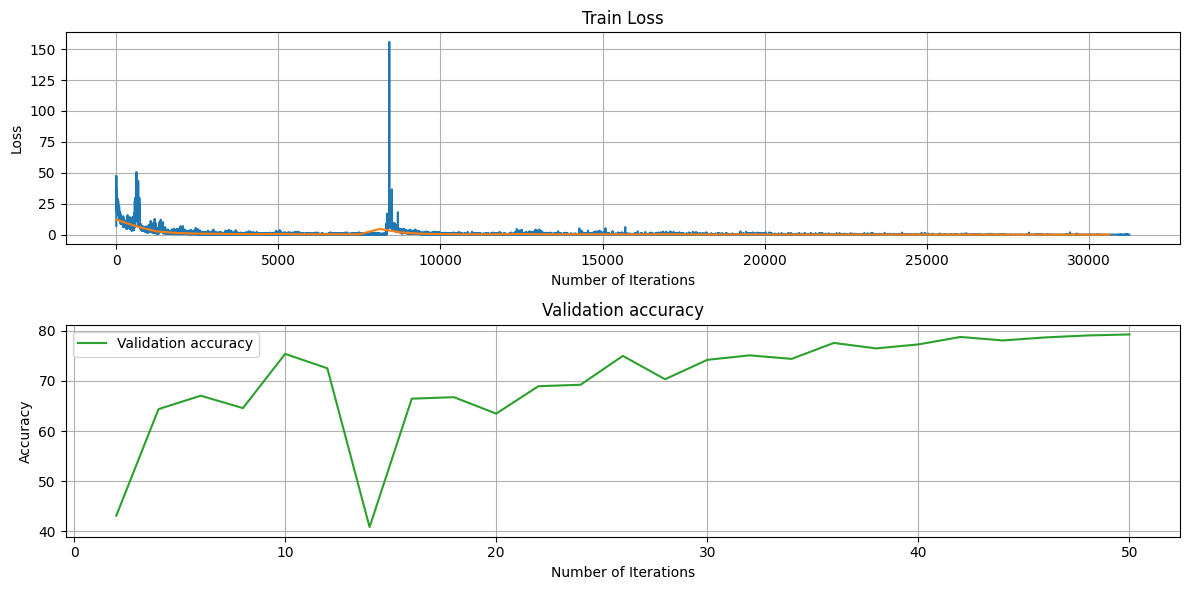

In [ ]:
# Вывод графика обучения
runner_ce.plot_loss()

In [ ]:
# Подготовка гиперпараметров для обучения модели с ArcFaceLoss
lr = 1e-3
num_epochs = 50

optimizer = optim.Adam(fr_arc.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)

In [ ]:
# Создаем класс для обучения модели с ArcFaceLoss
runner_arc = Runner(fr_arc, optimizer, train_dataloader, scheduler=scheduler, val_dataloader=val_dataloader, val_every=2)

In [ ]:
# Запустим само обучение модели
if TRAIN:
    torch.cuda.empty_cache()
    runner_arc.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

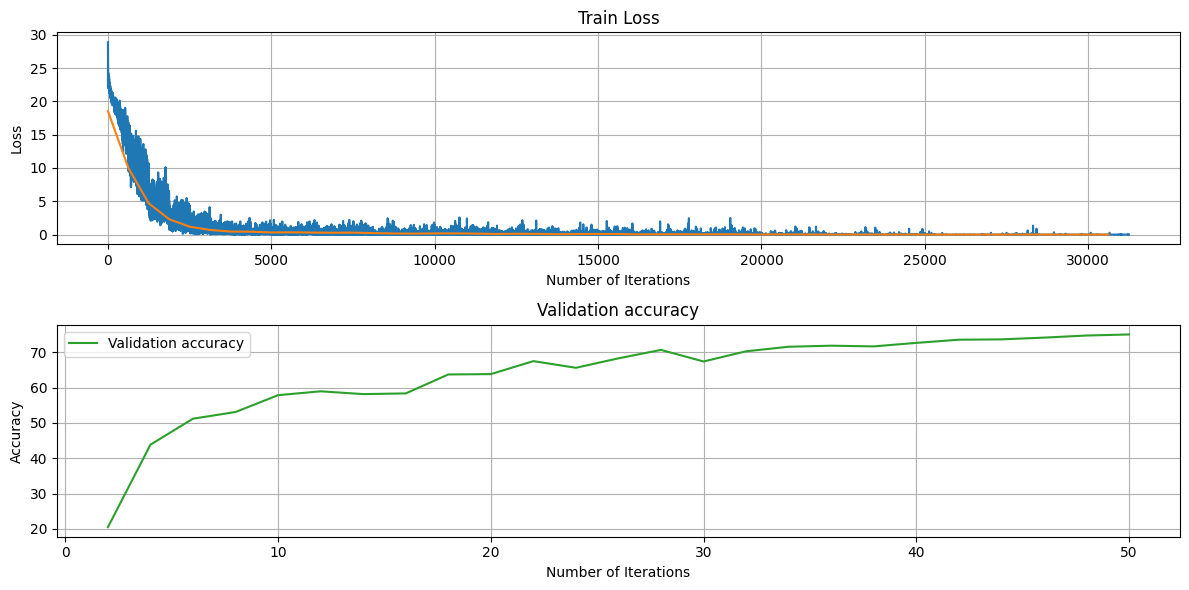

In [ ]:
# Вывод графика обучения
runner_arc.plot_loss()

## 6. Результат обучения

In [ ]:
# Веса модели можно скачать с Я.Диска (https://disk.yandex.ru/d/bhR7mvA_jrpPvQ, папка 'models')
try:
    fr_arc = FaceRecorgnizer(model_name="efficientnet_b3", loss_class=ArcFaceLoss, feat_dim=512).to(DEVICE)
    fr_arc.to(DEVICE)
    fr_arc.load_state_dict(torch.load("model_FR_ArcFaceLoss_0.7500_epoch_50_B3.weights", weights_only=True, map_location=torch.device('cpu')))
    fr_arc.eval()
except FileNotFoundError:
    print("Файл модели не найден!")

In [ ]:
# Веса модели можно скачать с Я.Диска (https://disk.yandex.ru/d/bhR7mvA_jrpPvQ, папка 'models')
try:
    fr_ce = FaceRecorgnizer(model_name="efficientnet_b3", loss_class=CE_loss, feat_dim=512).to(DEVICE)
    fr_ce.to(DEVICE)
    fr_ce.load_state_dict(torch.load("model_FR_CE_loss_0.7927_epoch_50_B3.weights", weights_only=True, map_location=torch.device('cpu')))
    fr_ce.eval()
except FileNotFoundError:
    print("Файл модели не найден!")

In [ ]:
print(f"Accuracy модели с CE loss на тренировочной выборке: {100 * runner_ce.validate(train_dataloader):.2f} %")
print(f"Accuracy модели с CE loss на валидационной выборке: {100 * runner_ce.validate(val_dataloader):.2f} %")

Running validation: getting validation features:   0%|          | 0/625 [00:00<?, ?it/s]

Accuracy модели с CE loss на тренировочной выборке: 99.30 %


Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy модели с CE loss на валидационной выборке: 78.47 %


In [ ]:
print(f"Accuracy модели с ArcFaceLoss на тренировочной выборке: {100 * runner_arc.validate(train_dataloader):.2f} %")
print(f"Accuracy модели с ArcFaceLoss на валидационной выборке: {100 * runner_arc.validate(val_dataloader):.2f} %")

Running validation: getting validation features:   0%|          | 0/625 [00:00<?, ?it/s]

Accuracy модели с ArcFaceLoss на тренировочной выборке: 99.98 %


Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy модели с ArcFaceLoss на валидационной выборке: 75.10 %


In [ ]:
cos_sim_metric_ce, _, _, _ = runner_ce.validate(val_dataloader, cosine_similarity_metric=True)
print(f"Accuracy по cosine_similarity модели с CE loss на валидационной выборке: {100 * cos_sim_metric_ce:.2f} %")

Running validation: getting gallery matrix...:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy по cosine_similarity модели с CE loss на валидационной выборке: 76.50 


In [ ]:
cos_sim_metric_arc, _, _, _ = runner_arc.validate(val_dataloader, cosine_similarity_metric=True)
print(f"Accuracy по cosine_similarity модели с ArcFaceLoss на валидационной выборке: {100 * cos_sim_metric_arc:.2f} %")

Running validation: getting gallery matrix...:   0%|          | 0/625 [00:00<?, ?it/s]

Running validation: getting validation features:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy по cosine_similarity модели с ArcFaceLoss на валидационной выборке: 92.10


## 7. Проверка работы

Посмотрим на работу распознавания

In [25]:
# Выберем id картинки для поиска
image_id_to_check = 1603

In [ ]:
df_temp = df_train.copy()

In [ ]:
# Посмотрим на выбранные картинки
temp_dataset = FaceIDDataset(df_temp[df_temp['id'] == image_id_to_check], "./train_dataset_aligned/", le, transforms=transform)
temp_dataloader = DataLoader(temp_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)
image, image_id, face_id = next(iter(temp_dataloader))

In [ ]:
# Имена картинок и метка класса (после LabelEncoder)
image_id, face_id

(('142192.jpg',
  '076250.jpg',
  '112615.jpg',
  '086609.jpg',
  '058145.jpg',
  '058306.jpg',
  '145904.jpg',
  '120868.jpg',
  '069662.jpg'),
 tensor([45, 45, 45, 45, 45, 45, 45, 45, 45]))

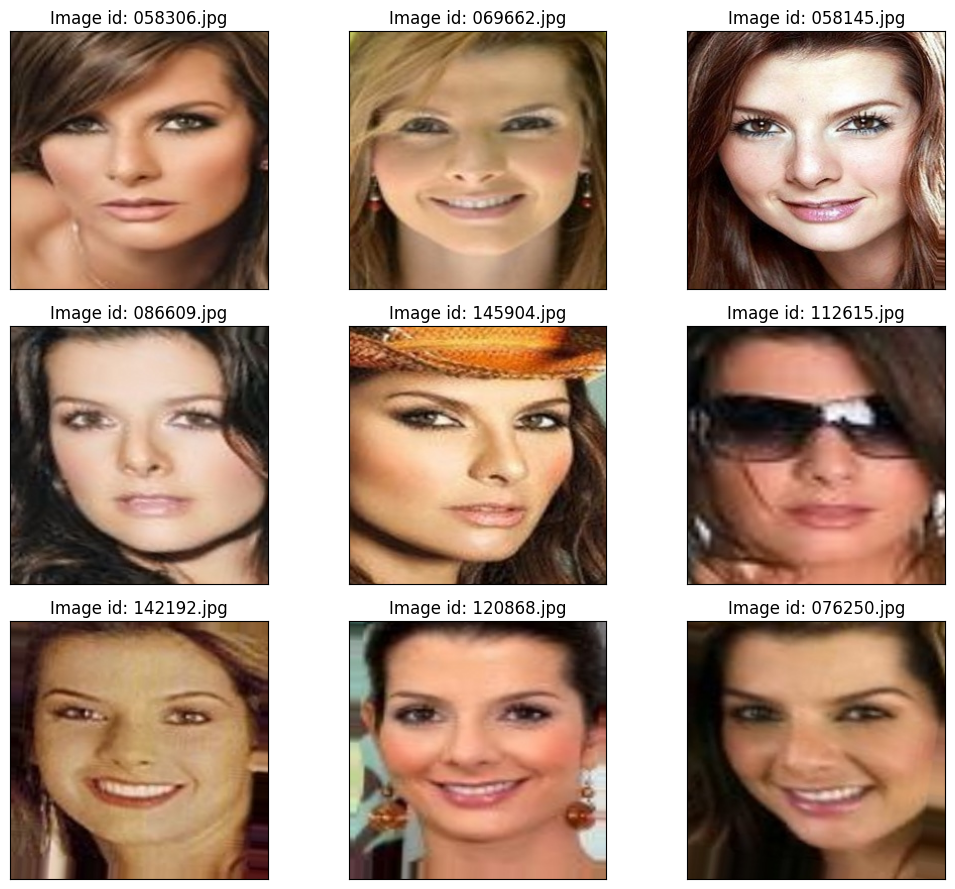

In [ ]:
# Отрисуем картинки
def plot_image_tensor(images, image_ids, num_examples=6, ncolumns=3, row_figsize=(12, 3)):
    indices = np.random.choice(images.shape[0], size=num_examples, replace=False)
    ncols = min(num_examples, ncolumns)
    nrows = math.ceil(num_examples / ncolumns)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        image = images[ix]
        img = np.array(image)
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0)).copy()

        ax.imshow(img)
        ax.set_title(f"Image id: {image_ids[ix]}")
        ax.set_xticks([])
        ax.set_yticks([])

plot_image_tensor(image, image_id, num_examples=9, ncolumns=3, row_figsize=(12, 3))

Действитель все лица похожи и принадлежат одному человеку)

In [ ]:
# Проверим что метка класса соответствует id картинки
le.transform([image_id_to_check])

array([45])

In [ ]:
# Запускаем модель на данных (тренировочных) картинках
fr_arc.eval()
image = image.to(DEVICE)
face_id = face_id.to(DEVICE)
_, output = fr_arc(image, face_id)

In [ ]:
# Смотрим результат
output.argmax(dim=1)

tensor([45, 45, 45, 45, 45, 45, 45, 45, 45], device='cuda:0')

Видно, что все классы определены корректно. Но это тренировочные картинки, возможна модельл их просто "выучила". Посмотрим на картинку из валидационного датасета, которую модель не видела при обучении:

In [ ]:
# Подготовка картинки из валидационного датасета
temp_val_dataset = FaceIDDataset(df_val[df_val['id'] == image_id_to_check], "./val_dataset_aligned/", le, transforms=transform)

temp_val_dataloader = DataLoader(temp_val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

image, image_id, face_id = next(iter(temp_val_dataloader))

In [ ]:
# Имя картинки и метка класса (после LabelEncoder)
image_id, face_id

(('058112.jpg',), tensor([45]))

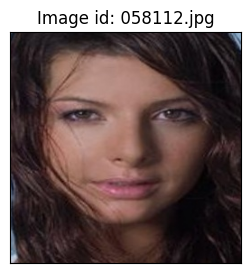

In [ ]:
# Отобразим валидационную картинку
def plot_image_tensor1(images, image_ids):

    fig, ax = plt.subplots(figsize=(12, 3))

    image = images[0]
    img = np.array(image)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)).copy()

    plt.imshow(img)
    plt.title(f"Image id: {image_ids[0]}")
    plt.xticks([])
    plt.yticks([])

plot_image_tensor1(image, image_id)

In [ ]:
# Запустим модель
fr_arc.eval()
image = image.to(DEVICE)
face_id = face_id.to(DEVICE)
_, output = fr_arc(image, face_id)

In [ ]:
# Посмотрим на результат
output.argmax(dim=1)

tensor([45], device='cuda:0')

In [27]:
# Инвертируем предсказанную метку обратно в id лица
le.inverse_transform([45])

array([1603])

Модель правильно соотнесла новую для себя картинку к нужному классу!